100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.86MB/s]


Epoch [1/20], Loss: 0.0693
Epoch [2/20], Loss: 0.0489
Epoch [3/20], Loss: 0.0422
Epoch [4/20], Loss: 0.0400
Epoch [5/20], Loss: 0.0384
Epoch [6/20], Loss: 0.0373
Epoch [7/20], Loss: 0.0365
Epoch [8/20], Loss: 0.0358
Epoch [9/20], Loss: 0.0352
Epoch [10/20], Loss: 0.0348
Epoch [11/20], Loss: 0.0344
Epoch [12/20], Loss: 0.0340
Epoch [13/20], Loss: 0.0337
Epoch [14/20], Loss: 0.0335
Epoch [15/20], Loss: 0.0332
Epoch [16/20], Loss: 0.0330
Epoch [17/20], Loss: 0.0329
Epoch [18/20], Loss: 0.0327
Epoch [19/20], Loss: 0.0325
Epoch [20/20], Loss: 0.0324


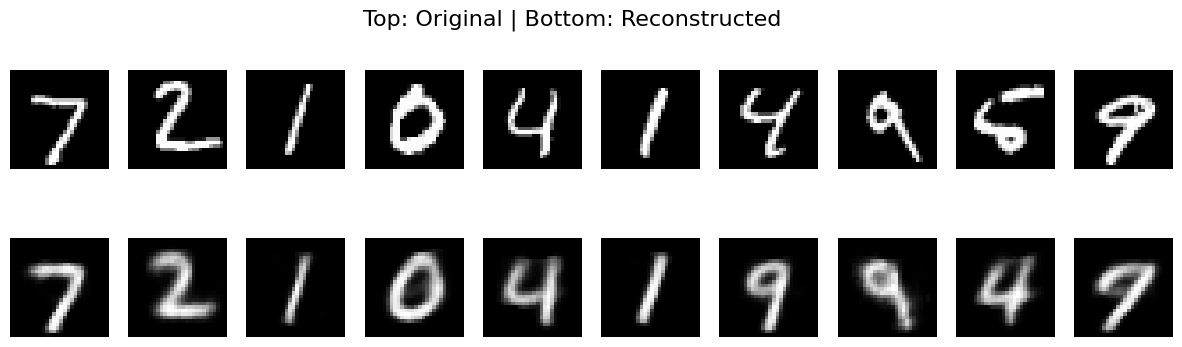

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. 데이터셋 로딩
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 2. AutoEncoder 모델
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # bottleneck (latent space)
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # 픽셀은 0~1 값이니까
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 3. 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. 학습
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # (batch, 28*28)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 5. 테스트 결과 확인 (이미지 복원)
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(images.size(0), -1).to(device)
        outputs = model(images)
        break  # 한 배치만 볼게

# 원본 이미지 vs 복원 이미지 비교
f, axarr = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    axarr[0, i].imshow(images[i].cpu().view(28,28), cmap='gray')
    axarr[0, i].axis('off')
    axarr[1, i].imshow(outputs[i].cpu().view(28,28), cmap='gray')
    axarr[1, i].axis('off')

plt.suptitle('Top: Original | Bottom: Reconstructed', fontsize=16)
plt.show()
